# Test model
This notebook is used to load the test features and predict the labels and confidence using the trained model.
The labels are then saved in a csv file. (Its name is defined in the constant `PRED_FILE`).

Finally, the predictions will be evaluated and saved in the evaluation file with the given NAME as index.

Parameters :
- MODEL_NAME : the name of the model to load
- FEATURES_FILE : the name of the csv containing the features of bimbas
- PRED_FILE : the name of the file to save the predictions (Set None if you don't want to save the predictions)
- EVAL_FILE : the name of the csv to save the evaluation
- NAME : the name of the evaluation (used as index in the evaluation file)

We will compare the predictions made with the real labels and compute the following metrics:
- recall
- precision
- weighted f1-score
- accuracy
- roc-auc
- num_contributors
- tn_fp_fn_tp

In [47]:
import joblib
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score


In [48]:
RESOURCE_FOLDER = '../resources'
DATA_FOLDER = f'{RESOURCE_FOLDER}/data/gitlab-dataset'
MODEL_FOLDER = f'{RESOURCE_FOLDER}/models'
EVAL_FOLDER = f'{RESOURCE_FOLDER}/evals'

FEATURES_FILE = 'gitlab_bot_features.csv'
MODEL_NAME = 'bimbis.joblib'

PRED_FILE = 'bimbis-glmap_predictions.csv'
EVAL_FILE = 'evaluation_gitlab.csv'
NAME = 'BIMBIS' # Name for the line in the evaluation file
MAPPING_NAME = 'glmap' # Name of the mapping used in the evaluation

RAND_SEED = 42

# 1 - Load features and labels

,label,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,NAR_std,NAR_gini,...,DCA_mean,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,
cogbot,Bot,195,1,2.0,2,1.0,97.5,97.5,135.057,0.490,...,1.153,0.356,4.264,0.735,0.848,NaN,NaN,0.000,0.000,NaN
project_278964_bot_a1e04ca047b466ba2f6534548fe23088,Bot,291,4,2.0,2,1.0,145.5,145.5,191.626,0.466,...,4.540,0.166,14.568,0.846,2.998,3.712,0.020,5.565,0.710,5.377
project_278964_bot_d928bc4aee0c73fc4ffa994d76825393,Bot,300,3,1.0,1,1.0,300.0,300.0,0.000,0.000,...,1.487,0.005,5.883,0.941,0.002,1.147,0.002,4.572,0.943,0.002
project_278964_bot_77e28085fcec07f14dfd31c689824b5b,Bot,299,4,1.0,1,1.0,299.0,299.0,0.000,0.000,...,3.045,0.022,11.221,0.861,1.486,2.897,0.011,11.572,0.874,1.478
group_12627982_bot_fa274bcce794e189d7608b786351d57e,Bot,6,1,2.0,2,1.0,3.0,3.0,0.000,0.000,...,268.802,0.001,368.071,0.600,672.002,NaN,NaN,0.000,0.000,NaN


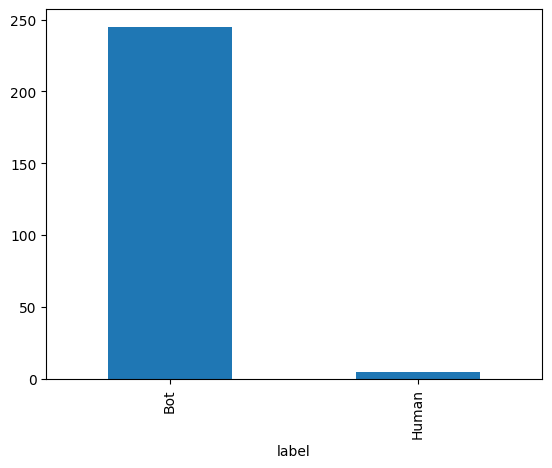

In [49]:
df_test = pd.read_csv(f"{DATA_FOLDER}/{FEATURES_FILE}")
df_test.set_index('contributor', inplace=True)
df_test = df_test[df_test['dataset'] == 'test']
df_test.drop(columns=['dataset'], inplace=True)

df_test['label'].value_counts().plot(kind='bar')
display(df_test.head())

In [50]:
df_label = df_test.copy()
df_label = df_label[['label']]
display(df_label.head())

df_test.drop(columns=['label'], inplace=True)

,label
contributor,
cogbot,Bot
project_278964_bot_a1e04ca047b466ba2f6534548fe23088,Bot
project_278964_bot_d928bc4aee0c73fc4ffa994d76825393,Bot
project_278964_bot_77e28085fcec07f14dfd31c689824b5b,Bot
group_12627982_bot_fa274bcce794e189d7608b786351d57e,Bot


# 2 - Load the model

In [51]:
model = joblib.load(f"{MODEL_FOLDER}/{MODEL_NAME}")

# 3 - Predict the labels

In [52]:
from rabbit import compute_confidence
import warnings


def predict(features, model):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        proba = model.predict_proba(features)
    return compute_confidence(proba[0][1])

In [53]:
# Create a df with 4 column but with the "contributor" column as index
df_prediction = pd.DataFrame(columns=['true_bot', 'predicted_bot'])
df_prediction = df_prediction.astype(int)

for contributor in df_test.index:
    true_bot = df_label.loc[contributor, 'label']
    y_prediction, confidence = predict(df_test.loc[[contributor]], model)
    new_row = pd.DataFrame([{
        'contributor': contributor,
        'true_bot': true_bot,
        'predicted_bot': y_prediction,
        'confidence': confidence
    }])
    # Set true_bot and predicted_bot as int
    new_row.set_index('contributor', inplace=True)
    df_prediction = pd.concat([df_prediction, new_row], ignore_index=False)

df_prediction.index.name = 'contributor'
display(df_prediction)

,true_bot,predicted_bot,confidence
contributor,,,
cogbot,Bot,Bot,0.909
project_278964_bot_a1e04ca047b466ba2f6534548fe23088,Bot,Bot,0.839
project_278964_bot_d928bc4aee0c73fc4ffa994d76825393,Bot,Bot,0.876
project_278964_bot_77e28085fcec07f14dfd31c689824b5b,Bot,Bot,0.841
group_12627982_bot_fa274bcce794e189d7608b786351d57e,Bot,Bot,0.077
...,...,...,...
project_64586918_bot_201df8156d1aed60bd88612d26438850,Bot,Bot,0.642
project_43688369_bot_320af1a92d3ee92f7ccb2ef9bc7b17fe,Bot,Bot,0.483
chessmango-renovatebot,Bot,Bot,0.565


# 4 - Save the predictions

In [54]:
if PRED_FILE:
    df_prediction.to_csv(f"{EVAL_FOLDER}/{PRED_FILE}", index=True)
else:
    print("No file to save the predictions")

# 5 - Evaluate the predictions

## 5.1 - Define the metrics

In [55]:
def evaluate_model(y_pred, y_true, target_names):
    """
    Compute the classification metrics and return them as a DataFrame. The accuracy is also returned.
    :return: report_df and the accuracy.
    """
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    return {
        'precision': [report['weighted avg']['precision']],
        'bot_precision': [report['Bot']['precision']],
        'human_precision': [report['Human']['precision']],
        'recall': [report['weighted avg']['recall']],
        'bot_recall': [report['Bot']['recall']],
        'human_recall': [report['Human']['recall']],
        'weighted_f1': [report['weighted avg']['f1-score']],
        'accuracy': [report['accuracy']],
        'roc_auc': [roc_auc_score(y_true, y_pred)],
        'tn_fp_fn_tp': [confusion_matrix(y_true, y_pred).ravel()],
        'num_contrib': [df_prediction.index.nunique()],
    }

## 5.2 - Evaluate the predictions

In [56]:
contributor_map = {
    'Bot': 1,
    'Human': 0
}

df_prediction['predicted_bot'] = df_prediction['predicted_bot'].map(contributor_map)
df_prediction['true_bot'] = df_prediction['true_bot'].map(contributor_map)
# Set column type to int
df_prediction['predicted_bot'] = df_prediction['predicted_bot'].astype(int)
df_prediction['true_bot'] = df_prediction['true_bot'].astype(int)

y_pred = df_prediction['predicted_bot']
y_test = df_prediction['true_bot']



performance = pd.DataFrame.from_dict(evaluate_model(y_pred, y_test, ['Human', 'Bot']))
performance.index = [NAME]
performance['mapping'] = MAPPING_NAME

In [57]:
display(performance)

,precision,bot_precision,human_precision,recall,bot_recall,human_recall,weighted_f1,accuracy,roc_auc,tn_fp_fn_tp,num_contrib,mapping
BIMBIS,0.980506,0.99177,0.428571,0.976,0.983673,0.6,0.977951,0.976,0.791837,"[3, 2, 4, 241]",250,glmap


## 5.3 - Save the evaluation

In [58]:
# Round the values
performance = performance.round(6)

In [59]:
df_eval = pd.read_csv(f"{EVAL_FOLDER}/{EVAL_FILE}", index_col=0)

In [60]:
# If the evaluation already exists, replace the line
if NAME in df_eval.index:
    df_eval.drop(index=NAME, inplace=True)
df_eval = pd.concat([df_eval, performance], axis=0)
df_eval.index.name = 'model'
df_eval.to_csv(f"{EVAL_FOLDER}/{EVAL_FILE}", index=True)